In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import flopy

In [2]:
sim = flopy.mf6.MFSimulation.load(sim_ws="model_ss")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package drn...
    loading package ghb...
    loading package oc...
  loading ims package new_york...


In [3]:
gwf = sim.get_model()

In [4]:
cbc = gwf.output.budget()

In [5]:
cbc.get_unique_record_names()

[b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'        DATA-SAT',
 b'             DRN',
 b'             GHB',
 b'             RCH']

In [6]:
sat = cbc.get_data(text="DATA-SAT")[0]

In [7]:
sat.dtype.names

('node', 'node2', 'q', 'sat')

In [8]:
sat["sat"].shape, sat["sat"].min(), sat["sat"].max()

((220,), 0.6984628983431364, 1.0)

In [9]:
spdis = cbc.get_data(text="DATA-SPDIS")[0]
spdis.dtype.names

('node', 'node2', 'q', 'qx', 'qy', 'qz')

In [10]:
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

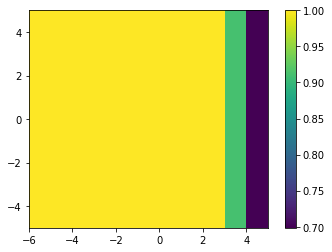

In [11]:
mv = flopy.plot.PlotMapView(model=gwf)
ps = mv.plot_array(sat["sat"])
plt.colorbar(ps)

In [12]:
head = gwf.output.head().get_data()

In [13]:
head.max()

2.9367584207872

In [14]:
dtw = gwf.dis.top.array - head[0]

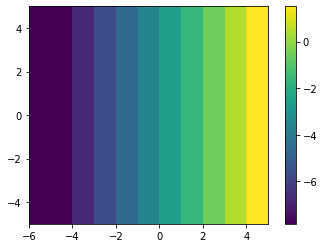

In [15]:
mv = flopy.plot.PlotMapView(model=gwf)
pv = mv.plot_array(dtw)
plt.colorbar(pv)

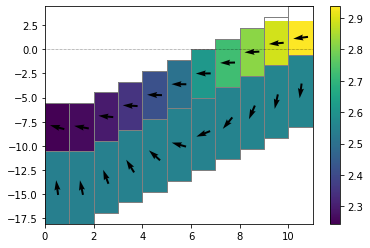

In [16]:
xs = flopy.plot.PlotCrossSection(model=gwf, line={"row": 5})
xs.ax.axhline(y=0.0, lw=0.5, ls=":", color="black")
pv = xs.plot_array(head, head=head)
xs.plot_vector(qx, qy, qz, head=head, normalize=True)
xs.plot_grid()
plt.colorbar(pv)

In [17]:
head[1]

array([[2.54159078, 2.54222488, 2.54345818, 2.54522041, 2.54740488,
        2.54986709, 2.55242275, 2.55484533, 2.55690758, 2.55841798,
        2.55922325],
       [2.54159068, 2.54222481, 2.54345814, 2.54522038, 2.54740484,
        2.54986704, 2.5524227 , 2.5548453 , 2.55690758, 2.55841802,
        2.55922329],
       [2.54159067, 2.54222477, 2.54345813, 2.54522037, 2.54740483,
        2.54986703, 2.55242268, 2.55484526, 2.55690754, 2.55841801,
        2.55922332],
       [2.54159068, 2.54222477, 2.54345812, 2.54522037, 2.54740484,
        2.54986704, 2.55242271, 2.55484529, 2.55690754, 2.55841801,
        2.55922334],
       [2.5415907 , 2.54222479, 2.54345813, 2.54522039, 2.54740485,
        2.54986705, 2.55242272, 2.55484532, 2.55690757, 2.55841802,
        2.55922336],
       [2.54159072, 2.54222481, 2.54345815, 2.54522041, 2.54740488,
        2.54986707, 2.55242274, 2.55484534, 2.55690761, 2.55841805,
        2.55922339],
       [2.54159075, 2.54222485, 2.54345817, 2.54522044, 2.